# Visualising FITS and star positions

## Import modules

In [2]:
import requests, math, glob
import pandas as pd
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.wcs import WCS
import astropy.units as u
from astropy.coordinates import Angle
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
#from astroquery.simbad import Simbad
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import os
os.chdir('/home/jovyan/work')
import init
import reading
import do_calibration

import importlib
importlib.reload(do_calibration)

%matplotlib inline
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

## Set reference frame, global vars

In [3]:
FITS_FILE=init.fitsdir+init.reference_frame
FITS_FILE_FTS=init.convfitsdir+'kout000001.fts'
wcs_file = init.basedir+"new-image.fits"
PADDING = 200

In [16]:
def getWcs(wcs_file):
    hdulist = fits.open(wcs_file)
    data = hdulist[0].data.astype(float)
    header = hdulist[0].header
    wcs = WCS(header)
    return wcs

wcs = getWcs(wcs_file)

#candidates = do_calibration.get_candidates(0.5)
hand_candidates_descr = do_calibration.get_star_descriptions(init.wwcra_certain_candidates)
#detections_catalog = do_calibration.create_detections_astropy_catalog(do_calibration.get_detected_stars())
detections = do_calibration.get_star_descriptions()
vsx_star_descr = do_calibration.get_vsx_in_field(detections, 0.01)
for star in vsx_star_descr:
    print(star.match)
    star.coords = star.match[0]['catalog_dict']['coords']
    

Reading star descriptions for: [6314, 5978, 5557, 5430, 4962, 3368, 2535, 2058, 1870, 1636, 464, 441, 427, 363, 290, 277, 227, 205, 141]
Reading star descriptions for: None
Adding VSX names to star descriptions
Creating vsx star catalog...
Creating astropy Catalog with 528255 objects...
Creating star_descriptions star catalog with 9999 stars...
Creating astropy Catalog with 9999 objects...
Found 18 stars
[{'catalog': 'VSX', 'separation': 0.0012810896775867747, 'catalog_dict': {'name': 'V0395 CrA', 'coords': <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.70646, -44.01222)>}}]
[{'catalog': 'VSX', 'separation': 0.0011005112176422575, 'catalog_dict': {'name': 'ASAS J180300-4336.3', 'coords': <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.75171, -43.60442)>}}]
[{'catalog': 'VSX', 'separation': 0.0014672551009306375, 'catalog_dict': {'name': 'ASASSN-V J180308.41-433330.4', 'coords': <SkyCoord (ICRS): (ra, dec) in deg
    ( 270.78504, -43.55845)>}}]
[{'catalog': 'VSX', 'separation': 0.00465556584

## Get comparison Star

In [17]:
comparison_star_descr = do_calibration.get_star_descriptions([reading.read_comparison_star()])
center_coord = SkyCoord.from_pixel(wcs._naxis1/2.0, wcs._naxis2/2.0, wcs)
apass_star_descr = do_calibration.get_apass_star_descriptions(center_coord, Angle(0.67, unit=u.deg), row_limit=10000)
print(len(apass_star_descr))

Reference star: 169, Aperture: 2

Reading star descriptions for: [169]
5061


In [18]:

def set_local_id_label(star_descriptions):
    for star_descr in star_descriptions:
        star_descr.label = star_descr.local_id
    return star_descriptions

def set_aavso_id_label(star_descriptions):
    for star_descr in star_descriptions:
        star_descr.label = star_descr.aavso_id
    return star_descriptions

def set_custom_label(star_descriptions, label):
    for index, star_descr in enumerate(star_descriptions):
        star_descr.label = label if isinstance(label, list) else label[index]
    return star_descriptions

def add_pixels(results, offset):
    for star in results:
        star_coord = star.coords
        xy = SkyCoord.to_pixel(star_coord, wcs=wcs, origin=0)
        x = xy[0].item(0)
        y = xy[1].item(0)
        star.xpos = x + offset
        star.ypos = y + offset
    return results

big_green = set_custom_label(comparison_star_descr, 'comp')
# small_red = set_custom_label(apass_star_descr, [o.vmag for o in apass_star_descr])
# big_green = set_custom_label(vsx_star_descr, [o.match['catalog_dict']['name'] for o in vsx_star_descr])
# small_red = set_custom_label(hand_candidates_descr, [o.local_id for o in hand_candidates_descr])
big_green = set_aavso_id_label(vsx_star_descr)
small_red = set_local_id_label(hand_candidates_descr)

big_green = add_pixels(big_green, PADDING)
small_red = add_pixels(small_red, PADDING)
print("nr of found result:", len(big_green), len(small_red))

nr of found result: 18 19


## Draw the image

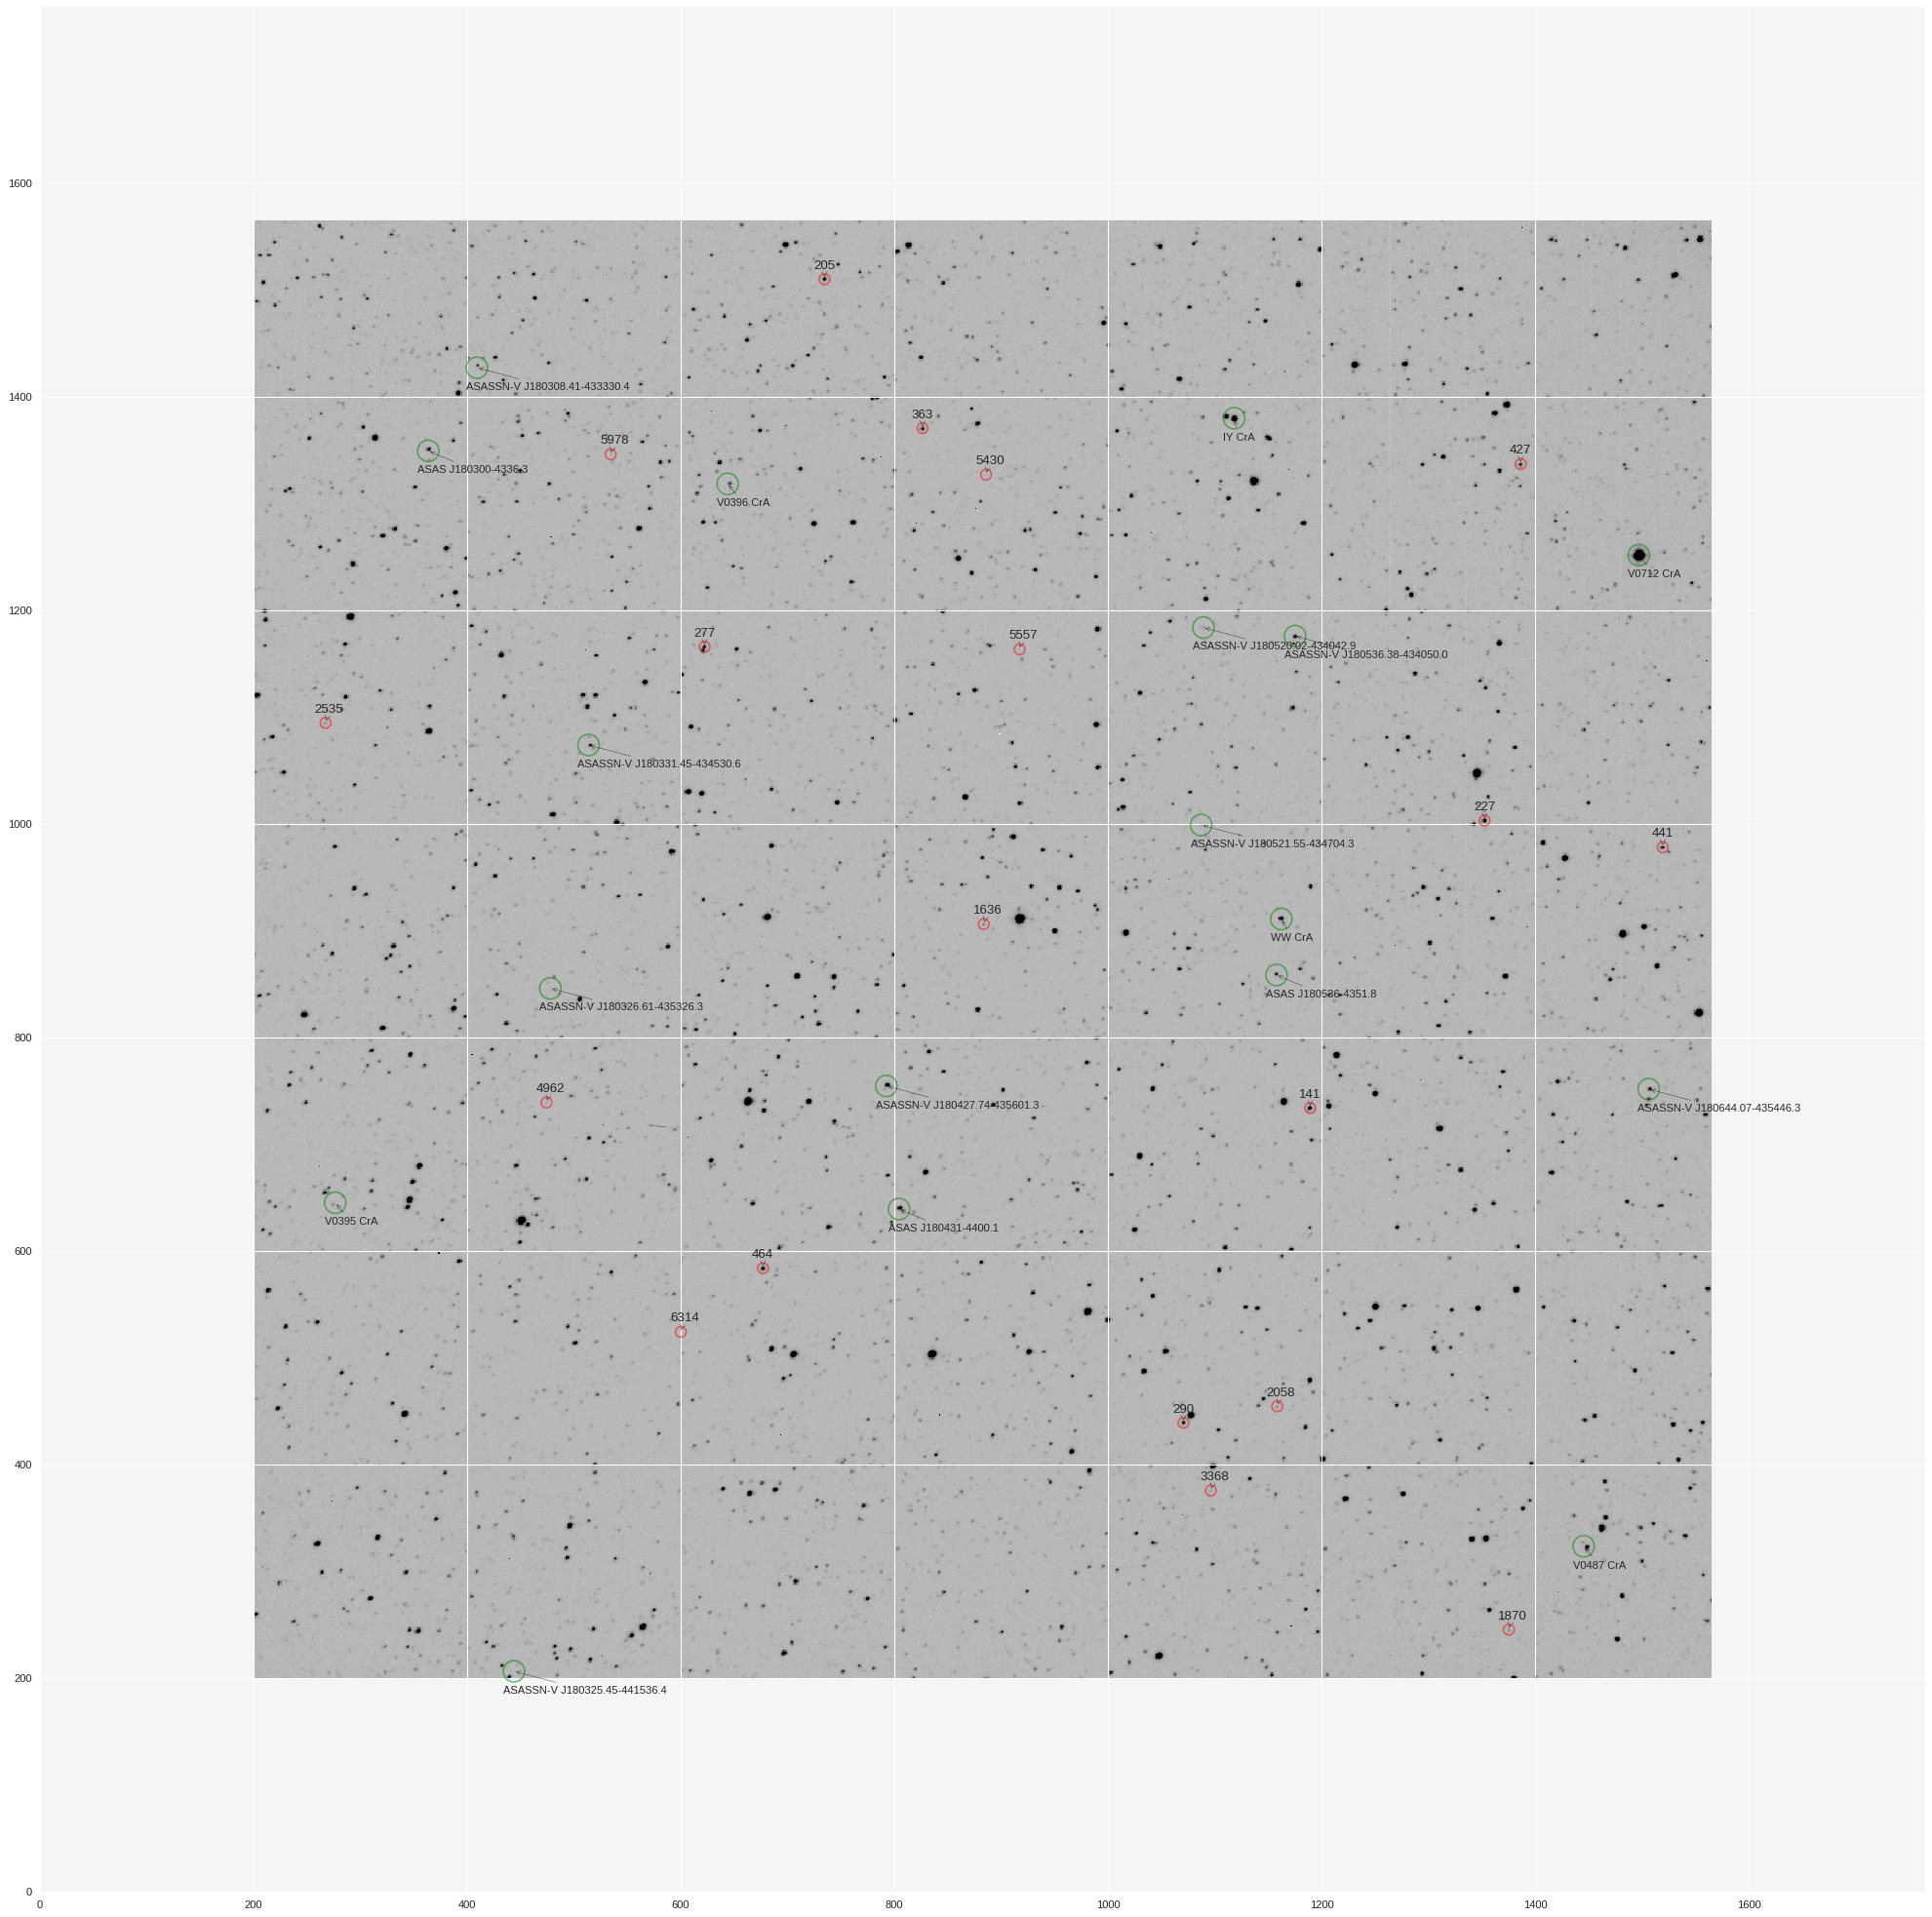

In [19]:
hdulist = fits.open(FITS_FILE)
data = hdulist[0].data.astype(float)
data = np.pad(data, (PADDING,PADDING), 'constant', constant_values=(100, 100))
fig=plt.figure(figsize=(36, 32), dpi= 80, facecolor='w', edgecolor='k')
big_green_positions = ([o.xpos for o in big_green],[o.ypos for o in big_green])
small_red_positions = ([o.xpos for o in small_red],[o.ypos for o in small_red])
big_green_apps = CircularAperture(big_green_positions, r=10.)    
small_red_apps = CircularAperture(small_red_positions, r=5.)    
# target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
big_green_apps.plot(color='green', lw=1.5, alpha=0.5)
small_red_apps.plot(color='red', lw=1.5, alpha=0.5)
# target_app.plot(color='blue', lw=1.5, alpha=0.5)
#to_plot = results
def annotate_it(results, offset1, offset2, size=16):
    for to_annotate in results:
        #star_name = to_annotate[1]['auid'] if to_annotate[1]['auid'] != 
        plt.annotate('{}'.format(to_annotate.label),
            xy=(to_annotate.xpos, to_annotate.ypos), xycoords='data',
            xytext=(offset1, offset2), textcoords='offset points', size=size, arrowprops=dict(arrowstyle="->"))
annotate_it(big_green, -10, -20, size=10)    
annotate_it(small_red, -10, 10, size=12)    


## Save the image

In [ ]:
fig.savefig(init.basedir+'known_vs_found_10k')
plt.close(fig)